# *Planet: Understanding the Amazon from Space* challenge

This notebook will show you how to do some basic manipulation of the images and label files.

In [1]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from skimage.transform import rescale

%matplotlib inline

## Setup
Set `PLANET_KAGGLE_ROOT` to the directory where you've downloaded the TIFF and JPEG zip files, and accompanying CSVs.

In [25]:
PLANET_KAGGLE_ROOT = os.path.abspath('C:/Kaggle/planet-amazon-deforestation-master')
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2/')
PLANET_KAGGLE_TEST_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'test-tif-v2/')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
MODEL_SAVE_FILE_NAME = 'forest-vgg-keras.tflearn'

assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
#print(PLANET_KAGGLE_JPEG_DIR)

In [4]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
rare_labels = ['slash_burn','conventional_mine','bare_ground','artisinal_mine','blooming','selective_logging','blow_down']
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']

In [5]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            #print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='tif'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

 ### Add onehot features for every label

In [6]:
def load_labels(labels_dir):

    labels_df = pd.read_csv(labels_dir)
    
    from collections import Counter
    total_counts = Counter()
    for labels in labels_df['tags']:
        total_counts.update(labels.split())
    
    vocab = sorted(total_counts, key=total_counts.get, reverse=True)
    
    # Add onehot features for every label
    for label in vocab:
        labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
        
    return labels_df

In [7]:
def subsample(df, n_sample):
    df_sample = pd.DataFrame()
    columns = list(df)

    i=0
    df_factor  = df.groupby(['tags'])['tags'].sum().sort_values().keys()
    for tags in df_factor:
            
            if tags == 'cloudy':
                sample = n_sample * 50
            else:
                sample = n_sample
                            
            
            df_s = df[df['tags'] == tags].sample(sample, replace=True)
            df_sample = df_sample.append(df_s)
            
    return df_sample[columns]
    

### loading multiple JPEG files, normalize and categorize labels

In [8]:
def load_images(img_dir,label_dir, img_fim=100, img_type='jpg', img_ini=0, img_rescale=1.0, sample=0):
    
    X = []
    y = []
    

    i = img_ini
    
    labels_df = load_labels(label_dir)
    columns = list(labels_df)

    if sample != 0:
        labels_df = subsample(labels_df, sample)[columns]
        img_ini = 0
        img_fim = len(labels_df) - 1
    
    labels_res = pd.DataFrame()
    
    print('Processando imagens '+ str(img_ini), str(img_fim) )
    
    for i in range(img_ini, img_fim):                        
                    
        try: 
            img_x = load_image(img_dir + labels_df.iloc[i].values[0] + '.' + img_type)
            
            if img_rescale != 1.0:    
                img_x = rescale(img_x, img_rescale, mode='reflect')
                
            y.append(labels_df.iloc[i].values[2:])    
            X.append(img_x/255)
            
            labels_res = labels_res.append(labels_df.iloc[i])
                
        except:
            if debug: print('ERRO LEITURA IMAGEM:',img_dir + labels_df.iloc[i].values[0] + '.' + img_type)
            pass
        
        
                
        if i >= len(labels_df) - 1:
            break
        
        
    X = np.array(X, dtype='float32')    
    
    one_hot_encode = np.array(y, dtype='float32')
        
    return X, one_hot_encode


In [9]:
#norm, one_hot, labels_df = load_images(PLANET_KAGGLE_JPEG_DIR, PLANET_KAGGLE_LABEL_CSV,
#                            img_ini=4848, 
#                            img_fim=4900, img_type='tif',                             
#                            sample=3)

In [10]:
#labels_dx = load_labels(PLANET_KAGGLE_LABEL_CSV)
#labels = subsample(labels_dx, 15)


In [11]:
#labels_df.iloc[1450]

In [12]:
#one_hot[1450]

In [13]:
#plt.imshow(norm[1450][:,:,3])

In [14]:
#img_x = load_image(PLANET_KAGGLE_JPEG_DIR + 'train_15960.tif')
#plt.imshow(img_x[:,:,3])

In [15]:
#labels_dx[labels_dx['image_name']=='train_15960']

In [16]:
def get_img_shape(rescale_img = 0.0):
    norm, one_hot = load_images(PLANET_KAGGLE_JPEG_DIR, PLANET_KAGGLE_LABEL_CSV,
                                img_ini=10, img_fim=11, 
                                img_type='tif', debug=True,
                                img_rescale=rescale_img)
    
    return [None, norm[0][:,:,:].shape[0], norm[0][:,:,:].shape[1], norm[0][:,:,:].shape[2]]
    

In [17]:
def load_data(img_dir,label_dir, img_ini=0, img_type='tif', batch_size=0, res_img=1.0, sample=0):
    labels_df = load_labels(label_dir)
    
    #Separar 10% do batch para teste
                
    img_fim = img_ini + batch_size - 1
    
    print(img_ini, img_fim)
        
    X_features, Y_features = load_images(img_dir,label_dir, img_fim, img_type, img_ini, img_rescale = res_img, sample=sample)
    
    if batch_size == 0:
        train_size = len(Y_features)
    else:
        train_size = int(0.9 * batch_size)
    
    
    return (X_features[:train_size], Y_features[:train_size]), (X_features[:-train_size], Y_features[:-train_size])
        
        

### Modelo Keras

In [18]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD


batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = True

from tensorflow import reset_default_graph


Using TensorFlow backend.


In [80]:
model = Sequential()

model.add(Conv2D(96, 11, padding='same', strides=4,
                 input_shape=(256,256,4),activation='relu', name='conv1_in'))
model.add(MaxPooling2D(pool_size=3, strides=2, name='pool1'))

model.add(Conv2D(256, 5, activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=3, strides=2, name='pool2'))

model.add(Conv2D(384, 3, activation='relu', name='conv3'))
model.add(Conv2D(384, 3, activation='relu', name='conv4'))
model.add(Conv2D(256, 3, activation='relu',name='conv5'))
model.add(MaxPooling2D(pool_size=3, strides=2, name='pool3'))

model.add(Flatten())

model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dropout(0.5))

model.add(Dense(17, activation='sigmoid', name='fc3_out'))

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



### Treinando em batches

In [81]:
#batch=5000
#
#i=20000
#while i <= 25000:
#
#    (X, Y), (X_test, Y_test) = load_data(PLANET_KAGGLE_JPEG_DIR,PLANET_KAGGLE_LABEL_CSV, 
#                                         img_ini=i, batch_size = batch,
#                                         res_img = set_rescale_img, sample=10)
#    
#    history = model.fit(X, Y,
#                        epochs=50,
#                        batch_size=128, 
#                        validation_data=(X_test, Y_test),)
#    
#    
#    i+= batch
#      
#    model.save(MODEL_SAVE_FILE_NAME)

### Treinando com as classes balanceadas

In [82]:
(X, Y), (X_test, Y_test) = load_data(PLANET_KAGGLE_JPEG_DIR,PLANET_KAGGLE_LABEL_CSV, 
                                     sample=10)

history = model.fit(X, Y,
                    epochs=50,
                    batch_size=128, 
                    validation_data=(X_test, Y_test), shuffle=True)
  
model.save(MODEL_SAVE_FILE_NAME)

0 -1
Processando imagens 0 4979


UnboundLocalError: local variable 'train_size' referenced before assignment

In [ ]:
#model.save(MODEL_SAVE_FILE_NAME)

In [21]:
model = keras.models.load_model('continue_2_forest-vgg.keras')

In [114]:
weight = classes.mean(0)

In [116]:
weight={0: 0.9267274389189456,
 1: 0.70236418883865703,
 2: 0.30423182390869341,
 3: 0.19938733664369179,
 4: 0.18308258603226366,
 5: 0.17937696089330271,
 6: 0.11060055831418761,
 7: 0.090417253390647004,
 8: 0.066627139998517756,
 9: 0.051607006101929392,
 10: 0.021294992465228885,
 11: 0.0083994169816448035,
 12: 0.00837471281405173,
 13: 0.0082017836409002207,
 14: 0.0051631710269522471,
 15: 0.0024210084241211493,
 16: 0.002470416759307295}

In [112]:
weight[1] = weight[0]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
#labels_df = load_labels(PLANET_KAGGLE_LABEL_CSV)

In [37]:
(X, Y), (X_test, Y_test) = load_data(PLANET_KAGGLE_JPEG_DIR,PLANET_KAGGLE_LABEL_CSV, 40000, batch_size = 10)



40000 40009
Processando imagens 40000 40009


In [22]:
#model.evaluate(X_test, y_tr, batch_size=128)

model.evaluate(X, Y, batch_size=128)

9/9 [==============================] - 3s


[0.48211684823036194, 0.92810463905334473]

In [38]:
classes = model.predict(X, batch_size=128)

In [26]:
classes[0]

array([  8.25952888e-01,   1.53789530e-02,   2.96323324e-05,
         1.83053874e-06,   1.81610358e-05,   2.32526122e-06,
         2.89289120e-10,   1.06402875e-09,   3.83834839e-02,
         1.77535981e-01,   1.17580178e-07,   1.04927498e-15,
         1.55368268e-15,   1.37890484e-14,   7.74605278e-16,
         3.20170958e-15,   1.63325267e-12], dtype=float32)

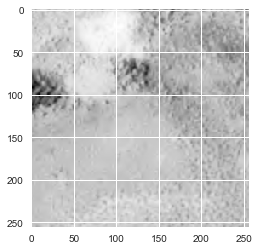

In [27]:
plt.imshow(X[0][:,:,3])

In [34]:
labels_dx = load_labels(PLANET_KAGGLE_LABEL_CSV)

In [35]:
list_labels = labels_dx.columns[2:]

In [55]:
thresholds = []
predictions_labels = []
for prediction in classes:
    labels = [list_labels[i] for i, value in enumerate(prediction) if value > 0.5]
    predictions_labels.append(labels)
    
predictions_labels[110]

['primary', 'clear', 'agriculture']

In [56]:
thresholds = []
predictions_labelsY = []
for prediction in Y:
    labels = [list_labels[i] for i, value in enumerate(prediction) if value > 0.5]
    predictions_labelsY.append(labels)
    
predictions_labelsY[110]

['primary', 'agriculture', 'road', 'partly_cloudy']

In [87]:
classes.mean(0)

array([  9.36532855e-01,   7.23094285e-01,   3.09244752e-01,
         1.50620297e-01,   1.21768683e-01,   1.59920111e-01,
         1.21176414e-01,   4.65232991e-02,   7.14944601e-02,
         4.45699841e-02,   2.78036986e-02,   7.88705703e-03,
         2.57723336e-03,   1.33771934e-02,   2.96922517e-04,
         1.33737485e-04,   1.33798085e-05], dtype=float32)

In [54]:
list_labels

Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')

In [58]:
word2idx['primary']

0

In [71]:
classes[0] > 0.5

array([ True,  True,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False], dtype=bool)

In [88]:
thresholds = []
predictions_labels = []
for prediction in classes:
    labels = [list_labels[i] for i, value in enumerate(prediction) if value > classes.mean(0)[i]]
    predictions_labels.append(labels)

In [89]:
predictions_labels

[['primary', 'clear', 'agriculture', 'road', 'habitation', 'haze'],
 ['haze', 'cloudy'],
 ['primary', 'clear', 'blooming', 'slash_burn', 'blow_down'],
 ['primary', 'clear', 'water'],
 ['primary', 'clear', 'road'],
 ['primary', 'clear', 'blooming'],
 ['primary', 'clear', 'agriculture', 'road'],
 ['primary', 'agriculture'],
 ['primary',
  'clear',
  'haze',
  'bare_ground',
  'selective_logging',
  'artisinal_mine',
  'blooming',
  'slash_burn',
  'blow_down',
  'conventional_mine'],
 ['primary', 'clear', 'blooming'],
 ['primary', 'clear', 'agriculture', 'road', 'cultivation'],
 ['primary',
  'clear',
  'cultivation',
  'selective_logging',
  'blooming',
  'slash_burn'],
 ['primary', 'partly_cloudy', 'cloudy'],
 ['primary', 'clear'],
 ['primary', 'clear', 'blooming'],
 ['haze', 'cloudy'],
 ['primary', 'clear', 'agriculture', 'cultivation'],
 ['primary', 'clear', 'blooming'],
 ['primary', 'agriculture', 'road', 'water', 'partly_cloudy'],
 ['primary', 'clear', 'blooming'],
 ['primary', 'cl

In [39]:
def load_test_images(dir_list, img_ini, img_fim):
    X = []
    img_list = []
    for img_num in range(img_ini, img_fim):                   

            try: 
                img_x = load_image(PLANET_KAGGLE_TEST_DIR + dir_list[img_num])

                X.append(img_x/255)

                img_list.append(dir_list[img_num])

            except:
                if debug: print('ERRO LEITURA IMAGEM:',img_dir + labels_df.iloc[i].values[0] + '.' + img_type)
                pass
            
    X = np.array(X, dtype='float32')
    return X, img_list


In [45]:
batch=50

import os
dir_list = os.listdir(PLANET_KAGGLE_TEST_DIR)

i=0
while i < 50:

    X, img_list = load_test_images(dir_list, i, batch)

    print(X.shape)
    
    classes = model.predict(X, batch_size=10)
    
    i+= batch

labels_dx = load_labels(PLANET_KAGGLE_LABEL_CSV)

list_labels = labels_dx.columns[2:]
    
thresholds = []
predictions_labels = []
for prediction in range(len(classes)):
    labels = [list_labels[i] for i, value in enumerate(classes[prediction]) if value > 0.5]
    predictions_labels.append([dir_list[prediction] , labels])

(50, 256, 256, 4)


In [46]:
predictions_labels

[['file_0.tif', ['primary', 'clear']],
 ['file_1.tif',
  ['primary', 'clear', 'agriculture', 'road', 'water', 'habitation']],
 ['file_10.tif', ['primary', 'clear', 'road', 'water']],
 ['file_100.tif', ['primary', 'clear']],
 ['file_1000.tif', ['primary', 'clear', 'road', 'water', 'habitation']],
 ['file_10000.tif', ['primary', 'clear']],
 ['file_10001.tif', ['primary', 'clear', 'agriculture', 'road', 'water']],
 ['file_10002.tif', ['primary', 'clear']],
 ['file_10003.tif', ['primary', 'clear', 'agriculture', 'road', 'habitation']],
 ['file_10004.tif', ['primary', 'clear']],
 ['file_10005.tif', ['primary', 'clear']],
 ['file_10006.tif', ['primary', 'clear', 'agriculture', 'partly_cloudy']],
 ['file_10007.tif', ['cloudy']],
 ['file_10008.tif', ['primary', 'clear']],
 ['file_10009.tif', ['primary', 'clear', 'agriculture', 'road']],
 ['file_1001.tif', ['primary', 'agriculture', 'partly_cloudy']],
 ['file_10010.tif', ['primary', 'clear', 'water']],
 ['file_10011.tif', ['primary', 'clear']],